In [1]:
import sys

sys.path.append('/home/users/kokron/Projects/preLIMinary/')

from LIM_lightcone import paint_lightcone,make_survey
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
import time
import copy
from nbodykit.algorithms import FFTPower
%matplotlib inline

In [2]:
st = time.time()
test = make_survey(dict(halo_lightcone_dir='/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/',
                            lines=dict(CO=True),
                            models=dict(CO=dict(model_name='CO_Li16',model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_LCO':0.3})),
                           do_external_SFR = False, external_SFR = '',zmin = 2.4,zmax = 2.8,
                 output_root = "output/default"))
print(time.time() - st)

/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_173.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_90.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_179.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_6.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_102.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_83.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_77.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_125.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_71.fits
/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/lightcone_MDPL2UM_221.fits


/home/users/kokron/Projects/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


8.351052284240723


In [3]:
test.lines.keys()

dict_keys(['CO', 'CII', 'Halpha', 'Lyalpha', 'HI'])

In [4]:
observed_catalog = dict(RA= np.array([]),DEC=np.array([]),Zobs=np.array([]),signal=np.array([]))

for line in test.lines.keys():
    if test.lines[line]:
        inds = np.where(np.logical_and(test.nuObs_line_halo[line] >= test.nuObs_min,
                                       test.nuObs_line_halo[line] <= test.nuObs_max))[0]
        observed_catalog['RA'] = np.append(observed_catalog['RA'],test.halo_catalog['RA'][inds])
        observed_catalog['DEC'] = np.append(observed_catalog['DEC'],test.halo_catalog['DEC'][inds])
        observed_catalog['Zobs'] = np.append(observed_catalog['Zobs'],test.line_nu0[test.target_line]/test.nuObs_line_halo[line][inds]-1)
        

In [5]:
nuObs_line_halo = {}
for line in test.lines.keys():
    if test.lines[line]:
        nuObs_line_halo[line] = test.line_nu0[line]/(1+test.halo_catalog['Z'])

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


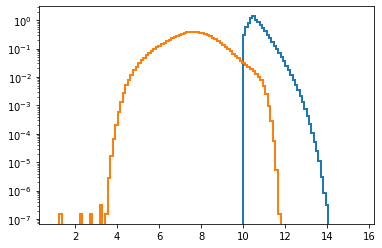

In [6]:
hmcat = np.log10(test.halo_catalog['M_HALO'])
smcat = np.log10(test.halo_catalog['SM_HALO'])

bins_hm = np.linspace(10, 15.5, 50)
bins_sm = np.linspace(1, 13, 100)
plt.hist(hmcat, bins=bins_hm, histtype='step', density=True, lw=2)
plt.hist(smcat, bins=bins_sm, histtype='step', density=True, lw=2)
plt.yscale('log')
plt.show()

# Nbodykit maps of intensity?

In [7]:
import nbodykit
from nbodykit.transform import SkyToCartesian
from nbodykit.source.catalog import ArrayCatalog


(array([5788777., 5817380., 5691944., 5531221., 5461057., 5315503.,
        5330299., 5274454., 5284716., 5160384.]),
 array([2.4139233, 2.4494176, 2.4849117, 2.520406 , 2.5559003, 2.5913944,
        2.6268888, 2.662383 , 2.6978774, 2.7333715, 2.7688658],
       dtype=float32),
 <a list of 10 Patch objects>)

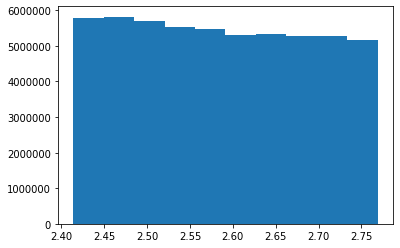

In [8]:
plt.hist(test.halo_catalog['Z'])

In [9]:
#Just use default cosmo for now - but specify to MDPL2
cosmo = nbodykit.cosmology.Cosmology()


cutcat = (test.halo_catalog['RA'] < np.max(test.halo_catalog['DEC']))&(test.halo_catalog['RA'] > np.min(test.halo_catalog['DEC']))


cartesian_halopos = SkyToCartesian(test.halo_catalog['RA'][cutcat], test.halo_catalog['DEC'][cutcat], test.halo_catalog['Z'][cutcat], cosmo)





Tony Li weights are temperature:


$$T = \frac{c^2 I_{\nu, obs}}{2 k_B \nu_{obs}^2}$$

and 

$$I_{\nu, obs} = L_{CO}/ 4\pi D_L^2 \delta_\nu$$

where $\delta_\nu$ is our `dnu` variable.

In [10]:
# test.observed_halos['signal']

In [11]:
lategrid = np.array(cartesian_halopos.compute())

for n in range(3):
    if np.min(lategrid[:,n]) < 0:
        lategrid[:,n] += np.abs(np.min(lategrid[:,n]))
    else:
        lategrid[:,n] -= np.min(lategrid[:,n])
nbodycat = np.empty(len(cartesian_halopos), dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = lategrid 



nbodycat['Weight'] = 1

Lboxes = np.zeros(3)

zmid = 2.4
#pathfinder resolution is 6 arcmin
#6 arcmin is 6*np.pi/(60*180) radians
#use angular diameter distance at z=2.4 to figure out what Lgrid_perp should be.
#Still an approximate treatment.

theta_pathfinder = 6*u.arcmin.to(u.rad)


#This either sets the fundamental grid spacing for perpendicular coordinates or the smoothing scale
#from the beam.
Lgrid_perp = cosmo.comoving_transverse_distance(zmid)*theta_pathfinder*0.5

#Lgrid par comes from taking the frequency spacing, converting to a delta-z, and then converting to dchi.
#Just get Nmesh_par by taking the survey bandwidth and dividing by the channel width.
dnu = (40*u.megahertz).to(u.gigahertz)

Dnu = 4*u.gigahertz

for n in range(3):
    Lboxes[n] = np.max(lategrid[:,n])-np.min(lategrid[:,n])
    

nmeshes = np.array([(Dnu/dnu).value, Lboxes[1]/Lgrid_perp, Lboxes[2]/Lgrid_perp], dtype=int)

cat = ArrayCatalog(nbodycat, Nmesh=nmeshes, BoxSize=Lboxes)
mesh = cat.to_mesh(Nmesh=nmeshes, BoxSize=Lboxes, value='Weight')
halopos = mesh.paint(mode='real')


In [12]:
def perp_filter(k, v):
    '''
    Filter for k_perp and k_par modes separately. 
    Applies to an nbodykit mesh object as a regular filter.
    
    "True input":
        Rperp - 'angular' smoothing in the flat sky approximation
        Rpar - 'radial' smoothing from number of channels.
    
    
    
    
    Usage:
        mesh.apply(perp_filter, mode='complex', kind='wavenumber')

    
    NOTES:
    k[0] *= modifies the next iteration in the loop.
    Coordinates are fixed except for the k[1] which are 
    the coordinate that sets what slab is being altered?
    
    '''
    rper = Rperp
    rpar = Rpar    
    newk = copy.deepcopy(k)
    
    
    #Smooth the k-modes anisotropically
    newk[0] *= rpar
    newk[1] *= rper
    newk[2] *= rper

    #Build smoothed values
    kk = sum(ki**2 for ki in newk)

    kk[kk==0]==1

    return np.exp(-0.5*kk)*v




lategrid = np.array(cartesian_halopos.compute())


#Translating grid such that bottom left corner of the box is [0,0,0] which is the nbodykit convention.
for n in range(3):
    if np.min(lategrid[:,n]) < 0:
        lategrid[:,n] += np.abs(np.min(lategrid[:,n]))
    else:
        lategrid[:,n] -= np.min(lategrid[:,n])
        
        
        
nbodycat = np.empty(len(cartesian_halopos), dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = lategrid 


#Nbodykit weights are L_CO
nbodycat['Weight'] = test.L_line_halo['CO'][cutcat].value 

Lboxes = np.zeros(3)

#Middle redshift of the survey
zmid = 2.6


#pathfinder resolution is 6 arcmin
#6 arcmin is 6*np.pi/(60*180) radians
#use angular diameter distance at z=2.4 to figure out what Lgrid_perp should be.
#Still an approximate treatment.

theta_pathfinder = 6*u.arcmin.to(u.rad)


#This either sets the fundamental grid spacing for perpendicular coordinates or the smoothing scale
#from the beam.
Lgrid_perp = cosmo.comoving_transverse_distance(zmid)*theta_pathfinder

#Lgrid par comes from taking the frequency spacing, converting to a delta-z, and then converting to dchi.
#Just get Nmesh_par by taking the survey bandwidth and dividing by the channel width.
dnu = (40*u.megahertz).to(u.gigahertz)

Dnu = 4*u.gigahertz

dz = (dnu)*(1+zmid)**2 / test.line_nu0['CO']


#Lgrid_par = dchi = dz / H(z*). Take z* = zmid
#Should be in little h units now?
Lgrid_par = dz/(cosmo.efunc(zmid)*100* (u.kilometer/(u.second*u.megaparsec)))  * (cu.c).to(u.kilometer/u.second)


#Figure out cartesian size spanned by the lightcone
for n in range(3):
    Lboxes[n] = np.max(lategrid[:,n])-np.min(lategrid[:,n])
    

#Get Nmeshes to build grid - supersample by N=10 for aesthetic purposes.
nmeshes = np.array([10*(Dnu/dnu).value, 10*Lboxes[1]/Lgrid_perp, 10*Lboxes[2]/Lgrid_perp], dtype=int)


#Build Nbodykit catalog object
cat = ArrayCatalog(nbodycat, Nmesh=nmeshes, BoxSize=Lboxes)

#Convert to a mesh, weighting by L_CO
mesh = cat.to_mesh(Nmesh=nmeshes, BoxSize=Lboxes, weight='Weight')


#Set globals for the anisotropic smoothing
#In the object-oriented framework these would be self.X quantities that are
#initialized when we start up the survey.
Rperp = Lgrid_perp
Rpar = Lgrid_par.to(u.gigaparsec).value



#Apply the filtering to create a separate, smoothed mesh
mesh_smooth = mesh.apply(perp_filter, mode='complex', kind='wavenumber')


#Paint the noiseless survey
LCO_survey = mesh.paint(mode='real')


#Paint the smoothed survey
LCO_survey_smooth = mesh_smooth.paint(mode='real')


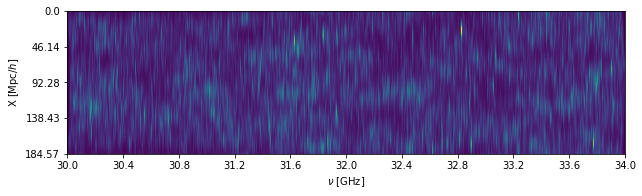

In [13]:
#Visualize the survey
plt.figure(figsize=(10, 10), facecolor='w')


N = 2

Nz, Nx, Ny = LCO_survey_smooth.shape


plt.imshow(LCO_survey_smooth.preview(axes=[N, 0]))


plt.xticks(np.linspace(0, Nz-1, 11), np.round(np.linspace(30, 34, 11), 2))

plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
plt.xlabel(r'$\nu$ [GHz]')

if N == 2:
    plt.ylabel(r'X [Mpc/$h$]')
elif N==1:
    plt.ylabel(r'Y [Mpc/$h$]')
# plt.colorbar()

Text(0.5, 0, 'Y [Mpc/$h$]')

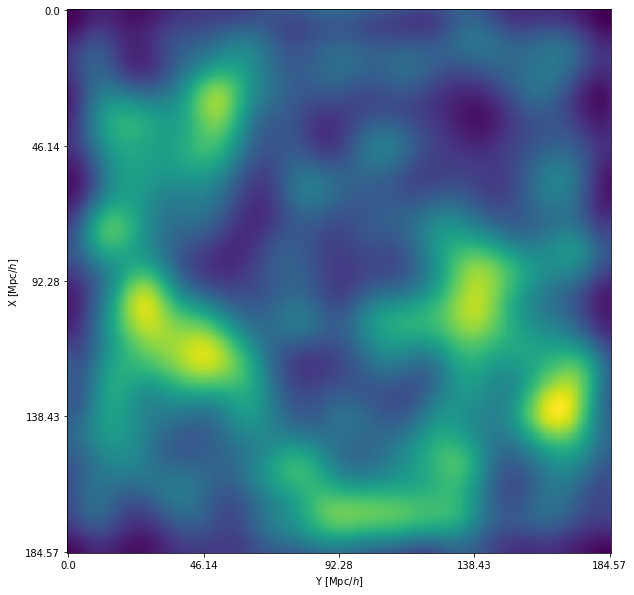

In [14]:
#Visualize the survey face-on
plt.figure(figsize=(10, 10), facecolor='w')


# N = 2

Nz, Nx, Ny = LCO_survey_smooth.shape


plt.imshow(LCO_survey_smooth.preview(axes=[2, 1]))


plt.xticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))

plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
# plt.xlabel(r'$\nu$ [GHz]')

plt.ylabel(r'X [Mpc/$h$]')
plt.xlabel(r'Y [Mpc/$h$]')
# plt.colorbar()

In [15]:
#Measure P(k) 
pk_lim = FFTPower(LCO_survey_smooth, '2d', Nmu=5, poles=[0,1,2,4], los=[1,0,0])

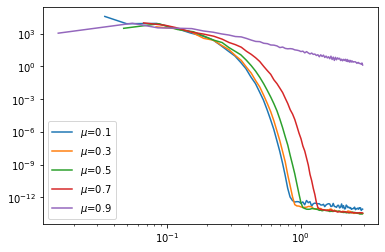

In [16]:
Pkmu = pk_lim.power

for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (Pkmu.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real , label=label)
# plt.ylim(1, 1e4)
plt.legend()

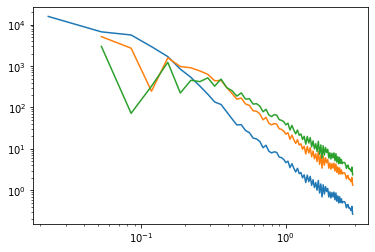

In [17]:
kvals = pk_lim.poles['k']


plt.loglog(kvals, np.abs(pk_lim.poles['power_0']).real)
plt.loglog(kvals, np.abs(pk_lim.poles['power_2'].real))
plt.loglog(kvals, np.abs(pk_lim.poles['power_4'].real))

# plt.k